# Abstract

The Bible is the best selling book of all times and continues to be a source for many pointing towards God. Originally written in Hebrew, Aramaic, and Greek, the Bible has been translated into over 600+ languages, with each respective language having its own respective variations and verisons.  

In this project, we will be examinign a few English Translations of the Bible and using some natural language procesing (NLP) tools in attempt to see how some of these versions are similar and how they differ.

The goal of this project is not to declare which versions are better or worse than another, but simply to see how these versions relate to one another, using Python and some machine learning techniques to quantify and make comparisons.

___________________________

# Project Overview

In order to compare the different Bibles versions, we will first need a source to pull the Bibles from.  For this project, we will utilize the following online APIs to pull Bible text:

* Biblia
* GetBible

Below is a diagram on what this project will look like:

![Project_Overview](./assets/resources/images/Capstone_Project_Overview.png "Overview")

_________________________________________________

### Import Files

In [3]:
import requests
import pandas as pd
import numpy as np
import json
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import io
import cv2
import nltk
from mpl_toolkits.axes_grid1 import ImageGrid
from plotly.subplots import make_subplots
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from keras import models
from keras.layers import Dense, Activation
from gensim.models import Word2Vec
from PIL import Image
from API import My_API
import text_handling as th

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.
C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\gensim\utils.py:1197: UserWarning:

detected Windows; aliasing chunkize to chunkize_serial



# Accessing APIs for Bible text

To store the different versions of the Bible, we will use a dictionary as the main structure to hold the content of each, called `versions`

In [ ]:
versions = {}

In this section, the most care had to be taken into consideration when pulling information from each API.  In an attempt to access the text as easily as possible, I am using a custom API to accesss each site. The queries are inserted and built by hand using the respective documentation at each site.  

#### Cannonical books

The API _Biblia API_ is a very useful site that is well documented and also has services built in to get the contents fo each specific bible.  To make the text retrieval process more seamless, the list of books within standard canonical bibles are retrieved, then stored for later use within different queries.

In [ ]:
## Pull the canonical books from Website
my_api = My_API(url="https://api.biblia.com/v1/bible/", key='fd37d8f28e95d3be8cb4fbc37e15e18e')
query = 'contents/KJV?'
resp = my_api.run_query(query)

## Strip out the books and remvoe whitespace with '_' 
# canonical_books = [book['passage'].replace(" ","_").strip() for book in resp['books']]
canonical_books = [book['passage'].strip() for book in resp['books']]

In [ ]:
print(canonical_books)

### Custom functions for Bible text retrieval and formatting

Text retrieval was the most difficult part of the project. Each API differs significantly and the format of the text returned made this even more difficult. To take care of these differences, custom functions were created and stored in the helper filed, _Text_Handling.py_

Format of downloaded text

To simplify the retrieval and storage of Bible text across different platforms, the text is stored as fully formatted verse as seen in the example below.

```
{"KJV":
   {
    "Genesis 1:1": "In the beginning God created heaven, and earth.",
    "Genesis 1:2": "And the earth was void and empty, and darkness was upon the face of the deep; and the spirit of God moved over the waters.",
    "Genesis 1:3": "And God said: Be light made. And light was made.",
    "Genesis 1:4": "And God saw the light that it was good; and he divided the light from the darkness.",
    ...
    "Revelation 22:21": "The grace of our Lord Jesus Christ be with you all. Amen."
    }
}
```

### _Biblia API_

This site is very useful and hosts a strong amount of services for pulling Bible text from the website.
Finding the right query to use was the most difficiult part of using this query.  

As a result, the decision was made to use the following versions below, and offset the remaining versions to another API:

Bible Version |	Version ID  
:---:     |:----:  |
1890 Darby Bible |	DARBY  
The Emphasized Bible |	EMPHBBL 
King James Version |	KJV1900  
The Lexham English Bible |	LEB

In [ ]:
biblia_available_versions = ['KJV1900','LEB','EMPHBBL','DARBY']

To get the content from a specific bible, the `content` service of the API has to be used.  Selecting different services is pretty simple.  To do so, you enter the name of the service as a path, within a directory as seen below.  

Pull the text for each book from website and store in dictionary for later use

In [ ]:
my_api = My_API(url="https://api.biblia.com/v1/bible/", key='fd37d8f28e95d3be8cb4fbc37e15e18e')

biblia_versions = {}

for v in biblia_available_versions:
    print(v)
    ver = {}
    for book in canonical_books:

        query = f'content/{v}.txt?passage={book}&style=oneVersePerLineFullReference'
        resp = my_api.run_query(query)

        book_dict = th.parse_formatted_verse_ref(resp)
        ver.update(book_dict)
        
    versions[v] = ver

In [ ]:
versions.keys()

### _GetBible.net_

This site was the easiest to use and gave the information in the ideal format.
Each verse was in its own respective JSON array, requiriing less effort to retrieve the information.

Below are the English BIble Versions available at this website:

Bible Version |	Version ID  
:---:     |:----:  
American Standard Version |	ASV 
Authorized Version |	KJV  
The Lexham English Bible |	LEB 
Young’s Literal Translation |	YLT
BasicEnglish Bible  | BASICENGLISH
Douary Rheims Bible | DOUAYRHEIMS
Webster's Bible  | WB
World English Bible | WEB


In [ ]:
getbible_eng_versions = ['KJV','AKJV','ASV','BASICENGLISH','DOUAYRHEIMS', 'WB','WEB','YLT']

In [ ]:
my_api = My_API(url="https://getbible.net/")

for v in getbible_eng_versions:
    v_dict = {}
    print(v)
    for book in canonical_books:
        resp = my_api.run_query(f'json?passage={book}&v={v.lower()}')
        resp_dict = json.loads(resp[1:-2])
        v_dict.update(th.parse_book(resp_dict))
    versions[v] = v_dict

In [ ]:
versions.keys()

### Save data to file

Here, we are saving the dictionary as a json object to a file, for easier access later on

In [ ]:
for key in versions.keys():
    key_dict = {key: versions[key]}
    with open(f"./data/{key}.json", "w") as f:
        js = json.dump(key_dict, fp=f, indent=4, separators=(',', ': '))

### Pull data from saved file

Pulling files from `/data` directory

In [4]:
from os import listdir
from os.path import isfile, join

mypath = './data'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [5]:
onlyfiles

['AKJV.json',
 'ASV.json',
 'BASICENGLISH.json',
 'DARBY.json',
 'DOUAYRHEIMS.json',
 'EMPHBBL.json',
 'KJV.json',
 'KJV1900.json',
 'LEB.json',
 'WB.json',
 'WEB.json',
 'YLT.json']

In [6]:
data = {}
for file in onlyfiles:
    with open(f"./data/{file}") as f:
        bible = json.load(f)
    data.update(bible)

In [7]:
for key in data.keys():
    print(key)

AKJV
ASV
BASICENGLISH
DARBY
DOUAYRHEIMS
EMPHBBL
KJV
KJV1900
LEB
WB
WEB
YLT


# General Statistics

Here, we will make a dataframe out of the parsed text to get a better idea of how the information is formatted.  All of the versions will be added and general statistics will be calculated to see how the available Bibles differ from one another.

Some of these statistics include the following:

`char_count` <br>
`word_count` <br>
`punctuation_count` <br>

In [8]:
# Create dataframes out of the Bible versions stored
list_of_df = []
for version in data.keys():
    content = []
    for item in data[version].items():
        ref, text = item

        book = ' '.join(ref.split()[:-1]).lower().replace(' ','_')
        chapter = ref.split()[-1].split(":")[0]
        verse = ref.split()[-1].split(":")[1]
        
        if book == 'psalm':
            book = 'psalms'
        if book == 'song_of_solomon':
            book = 'song_of_songs'

        content.append((version.lower(),book,chapter,verse,text))
    
    df = pd.DataFrame(data=content, columns=['version','book','chapter','verse','text'])
    list_of_df.append(df)

df = pd.concat(list_of_df)

Create general word statistics

In [9]:
df['char_count'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['punctuation_count'] = df['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df['title_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df['upper_case_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372964 entries, 0 to 31101
Data columns (total 11 columns):
version                  372964 non-null object
book                     372964 non-null object
chapter                  372964 non-null object
verse                    372964 non-null object
text                     372964 non-null object
char_count               372964 non-null int64
word_count               372964 non-null int64
word_density             372964 non-null float64
punctuation_count        372964 non-null int64
title_word_count         372964 non-null int64
upper_case_word_count    372964 non-null int64
dtypes: float64(1), int64(5), object(5)
memory usage: 34.1+ MB


In [11]:
df.head()

,version,book,chapter,verse,text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count
0,akjv,genesis,1,1,In the beginning God created the heaven and th...,54,10,4.909091,1,2,0
1,akjv,genesis,1,2,"And the earth was without form, and void; and ...",138,29,4.600000,4,4,0
2,akjv,genesis,1,3,"And God said, Let there be light: and there wa...",54,11,4.500000,3,3,0
3,akjv,genesis,1,4,"And God saw the light, that it was good: and G...",85,17,4.722222,3,3,0
4,akjv,genesis,1,5,"And God called the light Day, and the darkness...",115,22,5.000000,3,5,0


In [12]:
df.book.unique()

array(['genesis', 'exodus', 'leviticus', 'numbers', 'deuteronomy',
       'joshua', 'judges', 'ruth', '1_samuel', '2_samuel', '1_kings',
       '2_kings', '1_chronicles', '2_chronicles', 'ezra', 'nehemiah',
       'esther', 'job', 'psalms', 'proverbs', 'ecclesiastes',
       'song_of_songs', 'isaiah', 'jeremiah', 'lamentations', 'ezekiel',
       'daniel', 'hosea', 'joel', 'amos', 'obadiah', 'jonah', 'micah',
       'nahum', 'habakkuk', 'zephaniah', 'haggai', 'zechariah', 'malachi',
       'matthew', 'mark', 'luke', 'john', 'acts', 'romans',
       '1_corinthians', '2_corinthians', 'galatians', 'ephesians',
       'philippians', 'colossians', '1_thessalonians', '2_thessalonians',
       '1_timothy', '2_timothy', 'titus', 'philemon', 'hebrews', 'james',
       '1_peter', '2_peter', '1_john', '2_john', '3_john', 'jude',
       'revelation'], dtype=object)

In [13]:
## Tokenize text and add it as a column in the dataframe
# df['tokenize_verses'] = df['text'].apply(lambda x: th.tokenize_verse(x))

### Old Testament Comparison & New Testament Comparision against different versions

In [14]:
aggrts = df.groupby(['version']).agg('sum')

In [15]:
aggrts.columns

Index(['char_count', 'word_count', 'word_density', 'punctuation_count',
       'title_word_count', 'upper_case_word_count'],
      dtype='object')

In [ ]:
#Graph function to make bar graph
def generate_bar_graph(df=df, metric='', function='', title='Graph'):
    fig = go.Figure([go.Bar(x=[item[0]], y=[item[1]], 
                            name=item[0], showlegend=True) 
                     for item in df[metric].items()
                    ])
    fig.update_layout(title_text=title)
    fig.show()

In [ ]:
# generate_bar_graph(aggrts, metric='char_count', function='sum')

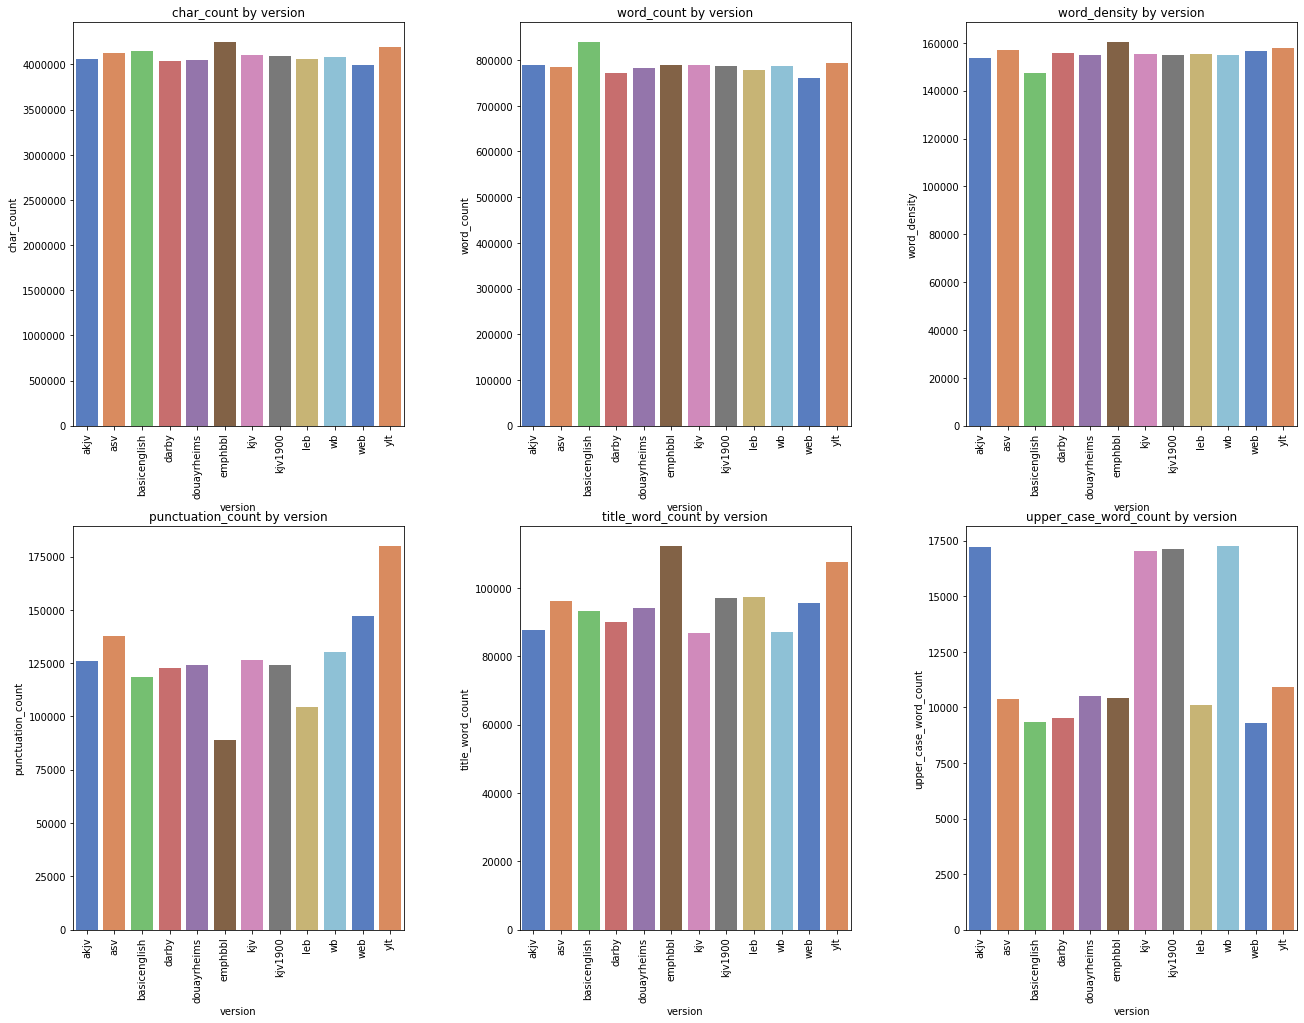

In [17]:
## Graph of metrics sums
columns, index = aggrts.columns, 0 
rows, cols = 2, len(columns)//2

fig, axs = plt.subplots(rows, cols, figsize=(20,15))

for i in range(0,rows):
    for j in range(0,cols):
        
        barplot = sns.barplot(x='version', y=columns[index], data=aggrts.reset_index(),
                    palette="muted", ax=axs[i][j])
        barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)
        barplot.set_title(label=f'{columns[index]} by version')
        barplot.xaxis.set_label([])
        index += 1

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, 
                    right=0.95, hspace=0.25, wspace=0.35)

### Mean metrics

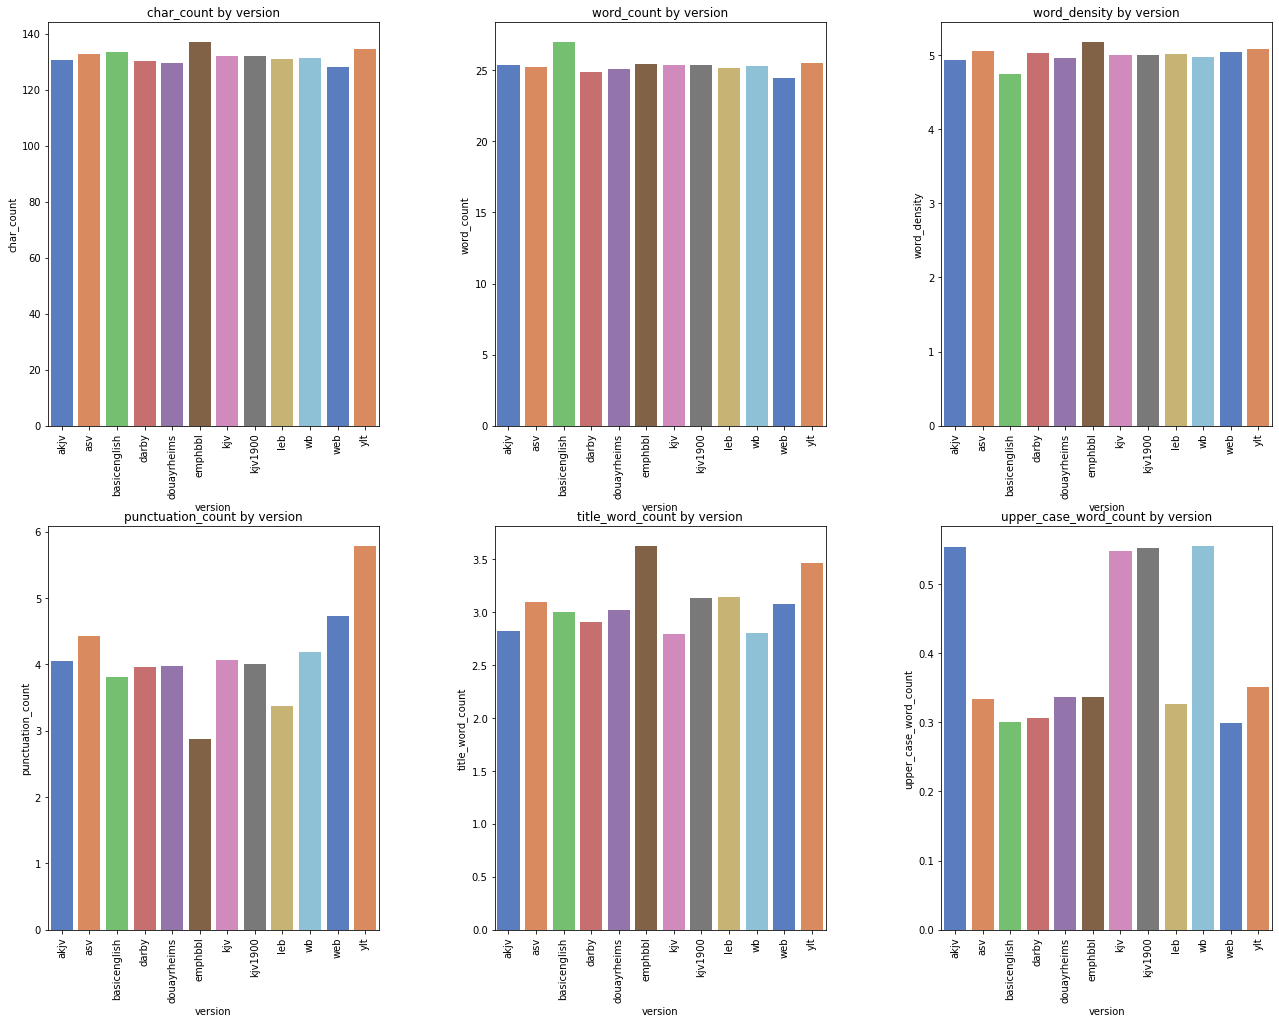

In [18]:
aggrts = df.groupby(['version']).agg('mean')

## Graph of metrics sums
columns, index = aggrts.columns, 0 
rows, cols = 2, len(columns)//2

fig, axs = plt.subplots(rows, cols, figsize=(20,15))

for i in range(0,rows):
    for j in range(0,cols):
        
        barplot = sns.barplot(x='version', y=columns[index], data=aggrts.reset_index(),
                    palette="muted", ax=axs[i][j])
        barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)
        barplot.set_title(label=f'{columns[index]} by version')
        barplot.xaxis.set_label([])
        index += 1

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

### Median metrics

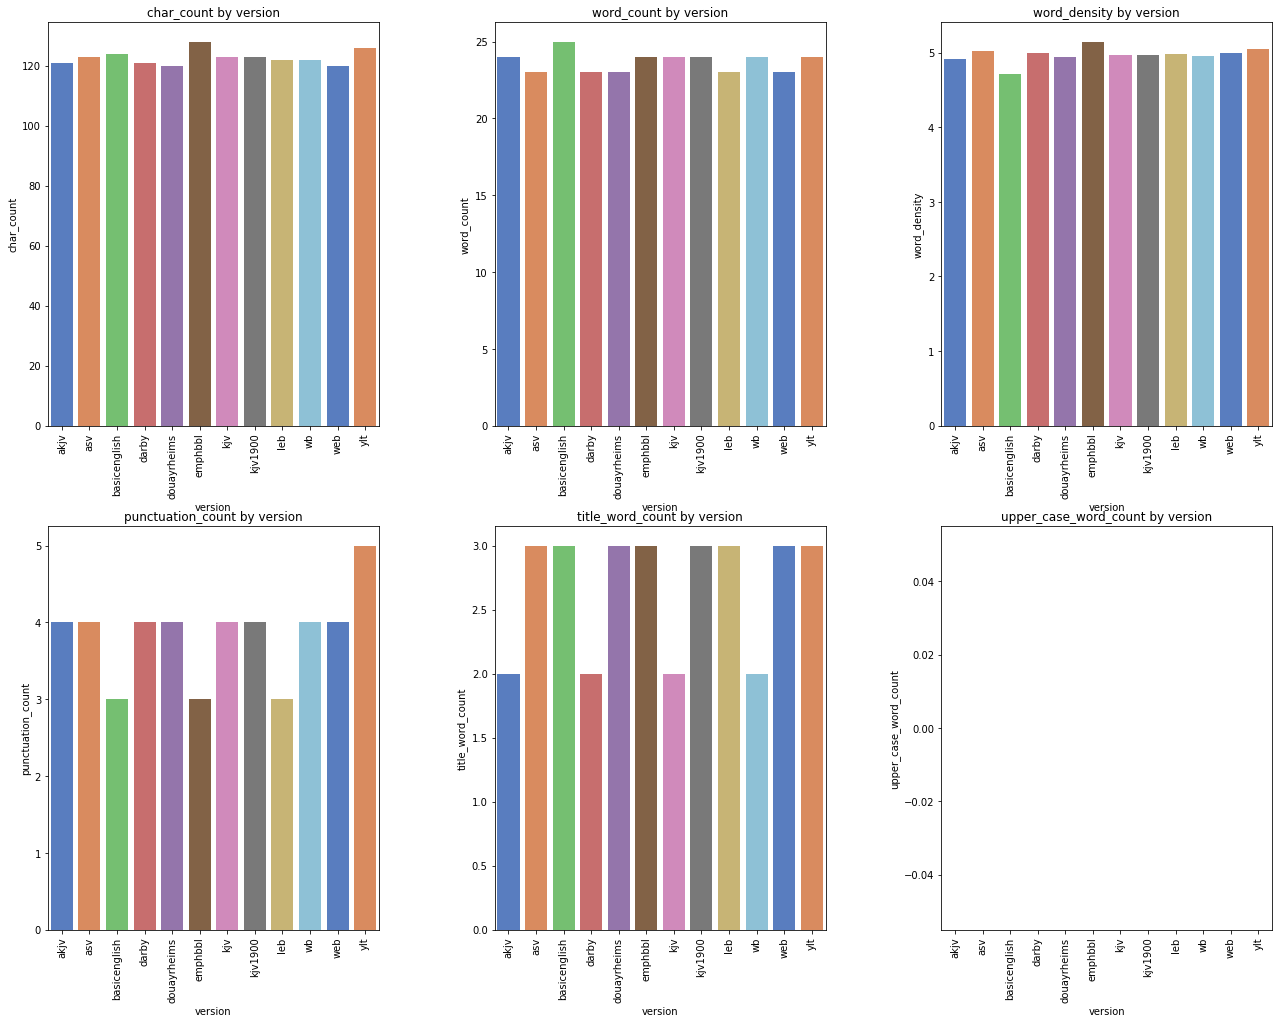

In [19]:
aggrts = df.groupby(['version']).agg('median')

## Graph of metrics sums
columns, index = aggrts.columns, 0 
rows, cols = 2, len(columns)//2

fig, axs = plt.subplots(rows, cols, figsize=(20,15))

for i in range(0,rows):
    for j in range(0,cols):
        
        barplot = sns.barplot(x='version', y=columns[index], data=aggrts.reset_index(),
                    palette="muted", ax=axs[i][j])
        barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)
        barplot.set_title(label=f'{columns[index]} by version')
        barplot.xaxis.set_label([])
        index += 1

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

# Modeling

### TF-IDF Vectorization

In [ ]:
## These are functions taken from Flat Iron Curriculum

def count_vectorize(line, vocab=None):

    if vocab:  
        for word in line:
            if word in vocab:
                vocab[word] += 1
            else: 
                vocab[word] = 1
        return vocab
        
    else:
        unique_words = list(set(line))

        text_dict = {i:0 for i in unique_words}
        
        for word in line:
            if word in text_dict:
                text_dict[word] += 1
            else :
                text_dict[word] = 1    
        
        return text_dict

def term_frequency(BoW_dict):
    total_word_count = sum(BoW_dict.values())
    
    for ind, val in BoW_dict.items():
        BoW_dict[ind] = val/ total_word_count
    
    return BoW_dict


def inverse_document_frequency(list_of_dicts):
    vocab_set = set()
    # Iterate through list of dfs and add index to vocab_set
    for d in list_of_dicts:
        for word in d.keys():
            vocab_set.add(word)
    
    # Once vocab set is complete, create an empty dictionary with a key for each word and value of 0.
    full_vocab_dict = {i:0 for i in vocab_set}
    
    # Loop through each word in full_vocab_dict
    for word, val in full_vocab_dict.items():
        docs = 0
        
        # Loop through list of dicts.  Each time a dictionary contains the word, increment docs by 1
        for d in list_of_dicts:
            if word in d:
                docs += 1
        
        # Now that we know denominator for equation, compute and set IDF value for word
        
        full_vocab_dict[word] = np.log((len(list_of_dicts)/ float(docs)))
    
    return full_vocab_dict


def tf_idf(list_of_dicts):
    
    # Create empty dictionary containing full vocabulary of entire corpus
    doc_tf_idf = {}
    idf = inverse_document_frequency(list_of_dicts)
    full_vocab_list = {i:0 for i in list(idf.keys())}
    
    # Create tf-idf list of dictionaries, containing a dictionary that will be updated for each document
    tf_idf_list_of_dicts = []
    
    # Now, compute tf and then use this to compute and set tf-idf values for each document
    for doc in list_of_dicts:
        doc_tf = term_frequency(doc)
        for word in doc_tf:
            doc_tf_idf[word] = doc_tf[word] * idf[word]
        tf_idf_list_of_dicts.append(doc_tf_idf)
    
    return tf_idf_list_of_dicts

In [ ]:
list_of_verses = df[(df.version=='asv')].text.apply(lambda x: th.tokenize_verse(x))
list_of_verses[:5]

In [ ]:
vocab_count = {}
for verse in list_of_verses:
     vocab_count = count_vectorize(verse, vocab_count)
        
vocab_count

In [ ]:
term_freq = term_frequency(vocab_count)

In [ ]:
# inverse_document_frequency([term_freq])
tf_idf([term_freq])

In [ ]:
for key in data:
    list_of_verses = list(data[key].values())
    
    vocab_count = {}
    for verse in list_of_verses:
         vocab_count = count_vectorize(verse, vocab_count)
    term_freq = term_frequency(vocab_count)
    tf_idf()

### TF-idf vectorizer using sklearn

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

In [ ]:
# list_of_verses = [' '.join(val) for val in data['KJV'].values()]
list_of_verses = df.loc[(df.version=='kjv')].text # .apply(lambda x: th.tokenize_verse(x))

In [ ]:
cv = CountVectorizer()
word_count_vector = cv.fit_transform(list_of_verses)

In [ ]:
word_count_vector.shape

__Compute the IDF values__

In [ ]:
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)

In [ ]:
# print idf values
idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
idf.sort_values(by=['idf_weights'])

__Compute the TFIDF score for the document__

In [ ]:
# count matrix
count_vector=cv.transform(list_of_verses)
 
# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [ ]:
feature_names = cv.get_feature_names()
 
#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]
 
#print the scores
df_vec = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df_vec.sort_values(by=["tfidf"],ascending=False)

### Word2Vector

Create the dictionary of models to hold the different models

In [20]:
versions_wv_dict = {}

In [21]:
for key in data.keys():
    vals = df[(df.version==key.lower())].text.apply(lambda x: th.tokenize_verse(x)).values
    model = Word2Vec(vals, size=100, window=5, min_count=1, workers=4)
    model.train(vals, total_examples=model.corpus_count, epochs=10)
    versions_wv_dict[key] = model.wv

In [22]:
words_to_check = ['salvation','resurrection','healing', 'redemption','hope','joy','peace']

Find the most similar words

In [23]:
index = 0
for word in words_to_check:
    for key in versions_wv_dict.keys():
        print(f"Version: {key} \t Word: {word}")
        try:
            similar_words = versions_wv_dict[key].most_similar(positive=[word], topn=10)
            for related in similar_words:
                print(related)
            print('\n\n')
        except KeyError:
            print(f"{word} not in the vocabulary")
            print('\n\n')

Version: AKJV 	 Word: salvation
('defense', 0.6906821727752686)
('strength', 0.6901434063911438)
('Father', 0.6790546178817749)
('faithfulness', 0.6633484959602356)
('mercies', 0.6485440731048584)
('prayer', 0.6431960463523865)
('hope', 0.62909334897995)
('joy', 0.6275311708450317)
('goodness', 0.625328779220581)
('Lead', 0.6202820539474487)



Version: ASV 	 Word: salvation
('Redeemer', 0.7297897338867188)
('lovingkindness', 0.6543046236038208)
('Father', 0.6490455865859985)
('strength', 0.6484163999557495)
('goodness', 0.6420180201530457)
('faithfulness', 0.6228456497192383)
('fortress', 0.6201319098472595)
('dwelling-place', 0.6194751858711243)
('righteousness', 0.607792854309082)
('rebuke', 0.5848723649978638)



Version: BASICENGLISH 	 Word: salvation
('strength', 0.659477710723877)
('reward', 0.6499365568161011)
('help', 0.6358147263526917)
('grace', 0.5936710834503174)
('glory', 0.5879794359207153)
('blessing', 0.5870475769042969)
('mercy', 0.5826022624969482)
('support', 0.5723

('prayer', 0.5813576579093933)
('supplication', 0.5617896318435669)
('sacrifice', 0.5375949740409851)
('sacrifices', 0.5225221514701843)
('righteousness', 0.5154324173927307)
('admired', 0.4997580647468567)
('offerings', 0.4962466359138489)
('faithfulness', 0.48696255683898926)
('faith', 0.4855688810348511)
('freewill', 0.47521185874938965)



Version: ASV 	 Word: peace
('mind', 0.6102413535118103)
('supplication', 0.587044358253479)
('prayer', 0.566883385181427)
('prosperity', 0.5657448172569275)
('protection', 0.5364698171615601)
('strength', 0.5343252420425415)
('answers', 0.5324010848999023)
('heart', 0.5322080850601196)
('patience', 0.5243277549743652)
('ears', 0.520628035068512)



Version: BASICENGLISH 	 Word: peace
('joy', 0.5061101317405701)
('quiet', 0.478712260723114)
('salvation', 0.47869446873664856)
('glad', 0.47602829337120056)
('memory', 0.46535903215408325)
('righteousness', 0.4648561477661133)
('pleasure', 0.46054601669311523)
('sorrow', 0.4502052068710327)
('faith', 

Find the least similar words

In [24]:
# Find the least similar for 
index = 0
for word in words_to_check:
    for key in versions_wv_dict.keys():
        print(f"Version: {key} \t Word: {word}")
        try:
            similar_words = versions_wv_dict[key].most_similar(negative=[word], topn=10)
            for related in similar_words:
                print(related)
            print('\n\n')
        except KeyError:
            print(f"{word} not in the vocabulary")
            print('\n\n')

Version: AKJV 	 Word: salvation
('rode', 0.4810250401496887)
('hastily', 0.4318574070930481)
('Lot', 0.4085233807563782)
('eightieth', 0.4013800323009491)
('fathoms', 0.39616966247558594)
('three', 0.38491812348365784)
('six', 0.3827510476112366)
('beget', 0.38262319564819336)
('eighteen', 0.3796796500682831)
('dragging', 0.3783673644065857)



Version: ASV 	 Word: salvation
('colts', 0.5623962879180908)
('fathoms', 0.4830929636955261)
('rode', 0.41826820373535156)
('thirty', 0.4159276783466339)
('eighteen', 0.4093627333641052)
('six', 0.4076398015022278)
('degenerate', 0.4020395576953888)
('some', 0.3908286690711975)
('three', 0.3863649368286133)
('eight', 0.385512113571167)



Version: BASICENGLISH 	 Word: salvation
('Noadiah', 0.5311957001686096)
('calmer', 0.4757176339626312)
('Bohan', 0.47211846709251404)
('Pi-hahiroth', 0.4607517719268799)
('Adummim', 0.46028077602386475)
('hardest', 0.4586360454559326)
('untrained', 0.4500288963317871)
('rooting', 0.44728654623031616)
('serious-

('about—Jesus', 0.3961271643638611)
('After', 0.39248713850975037)
('ordered', 0.37992727756500244)
('Hang', 0.3586556017398834)
('instructing', 0.356475293636322)
('lease', 0.356323778629303)
('behind', 0.3474089503288269)
('Iscariot', 0.34694045782089233)
('Sceva', 0.3408033549785614)
('Last', 0.3373778462409973)



Version: WB 	 Word: joy
('Hammedatha', 0.426765501499176)
('Micaiah', 0.37093937397003174)
('Tekoites', 0.3673221468925476)
('centurion', 0.36724382638931274)
('Bid', 0.3664802610874176)
('Balaam', 0.3520904779434204)
('Penuel', 0.34898558259010315)
('Abinoam', 0.34793221950531006)
('Zalaph', 0.345363974571228)
('repaired', 0.3442457318305969)



Version: WEB 	 Word: joy
('hitherto', 0.42566174268722534)
('disregards', 0.39899373054504395)
('Igdaliah', 0.3735809922218323)
('Gera', 0.3655436336994171)
('Nun', 0.3576081693172455)
('Bohan', 0.3323900103569031)
('named', 0.3320700526237488)
('Hammedatha', 0.3298252820968628)
('Matrites', 0.32962745428085327)
('Beor', 0.327185

## Word Cloud Representation

In this section, we have code to create a word cloud representation of books within the specified Bible.  This code can be ran on entire versions, to get further insight into similarities between different different versions and books.  I highly recommended going book by book.  Loading entire versions results in long load times.

In [25]:
from wordcloud import WordCloud, STOPWORDS

def get_stop_words(file_path=''):
    
    complete_stoplist = list(STOPWORDS) + list(nltk.corpus.stopwords.words('english'))
    
    if file_path:
        with open(file_path, 'r') as f:
            eliz_stopwords = f.readlines()
            
        eliz_stopwords = [word.strip() for word in eliz_stopwords]
        complete_stoplist += eliz_stopwords
    
    return set(complete_stoplist)

In [26]:
def generate_word_cloud(df=None, col='', stopwords=None, save_disp_flag=False, img_width=800, img_height=800):
    """
        Function to generate word cloud. This function generates the cloud and stores it in a file
        within the current directory
    """
    comment_words = ' '

    for val in df[col]:
        tokens = [token for token in th.tokenize_verse(val)]

        for words in tokens:
            comment_words = comment_words + words + ' '

    wordcloud = WordCloud(width = img_width, height = img_height, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words)
    
    return wordcloud.to_image()

code to create zoomable static image

In [27]:
# Create figure
def display_wordcloud(width=400, height=200, scl_factor=0.5, img_path='', display_flag=False):
    """
        Original code can be seen at Plotly site.  Modified so that it takes in an image file
        For
    """
    fig = go.Figure()

    # Constants
    img_width = width
    img_height = height
    scale_factor = scl_factor

    # Add invisible scatter trace.
    # This trace is added to help the autoresize logic work.
    fig.add_trace(
        go.Scatter(
            x=[0, img_width * scale_factor],
            y=[0, img_height * scale_factor],
            mode="markers",
            marker_opacity=0
        )
    )

    # Configure axes
    fig.update_xaxes(
        visible=False,
        range=[0, img_width * scale_factor]
    )

    fig.update_yaxes(
        visible=False,
        range=[0, img_height * scale_factor],
        # the scaleanchor attribute ensures that the aspect ratio stays constant
        scaleanchor="x"
    )

    # Add image
    fig.add_layout_image(
        dict(
            x=0,
            sizex=img_width * scale_factor,
            y=img_height * scale_factor,
            sizey=img_height * scale_factor,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="below",
            sizing="stretch",
            source=img_path)
    )

    # Configure other layout
    fig.update_layout(
        width=img_width * scale_factor,
        height=img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
    
    if display_flag:
        # Disable the autosize on double click because it adds unwanted margins around the image
        # More detail: https://plot.ly/python/configuration-options/
        fig.show(config={'doubleClick': 'reset'})
    
    return fig

In this block, we create the word cloud for the specified verison and book.

In [28]:
stop_list = get_stop_words(file_path='./assets/resources/custom_stopwords.txt')
image_width, image_height = 800, 800

Uncoment the lines below to and change the version & book fields, to generate plot.ly figure for respective version and book

In [36]:
# df_book = df.loc[((df.version=='asv') & (df.book=='john'))]

# image = generate_word_cloud(df_book, col='text', stopwords=stop_list)
# fig = display_wordcloud(width=image_width, height=image_height, img_path=image, display_flag=True)

In [37]:
# df_book = df.loc[((df.version=='ylt') & (df.book=='john'))]

# image = generate_word_cloud(df_book, col='text', stopwords=stop_list)
# fig = display_wordcloud(width=image_width, height=image_height, img_path=image, display_flag=True)

_Grid of WordClouds_

In [31]:
def generate_multi_wordcloud(df=None, version_list=None, book='genesis', display_flag=False,
                            stopword_list=None, grid_size=(33., 33.), image_width=400, 
                            image_height=400, rows=4, cols=3, axs_pad=0.5):
    
    fig = plt.figure(figsize=grid_size)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates rows x cols grid of axes
                     axes_pad=axs_pad,  # pad between axes in inch.
                     )
    
    for ax, version in zip(grid, version_list):
        
        df_book = df.loc[((df.version==version) & (df.book==book))]

        image = generate_word_cloud(df_book, col='text', stopwords=stopword_list, 
                                    img_height=image_height, img_width=image_width)        
        ax.imshow(image)
        ax.set_title(version.upper())
                
    if display_flag:
        plt.show()
    
    return fig

In [32]:
def fig2data(fig):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    site: http://www.icare.univ-lille1.fr/tutorials/convert_a_matplotlib_figure
    """
    # draw the renderer
    fig.canvas.draw()
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = (w, h, 4)
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll(buf, 3, axis=2)
    return buf

In [33]:
def fig2img(fig):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    site: http://www.icare.univ-lille1.fr/tutorials/convert_a_matplotlib_figure
    """
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape
    return Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) )

In [34]:
def get_img_from_fig(fig, dpi=180):
    """
        Function that generates high definition image and returns it as a numpy array
    """
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

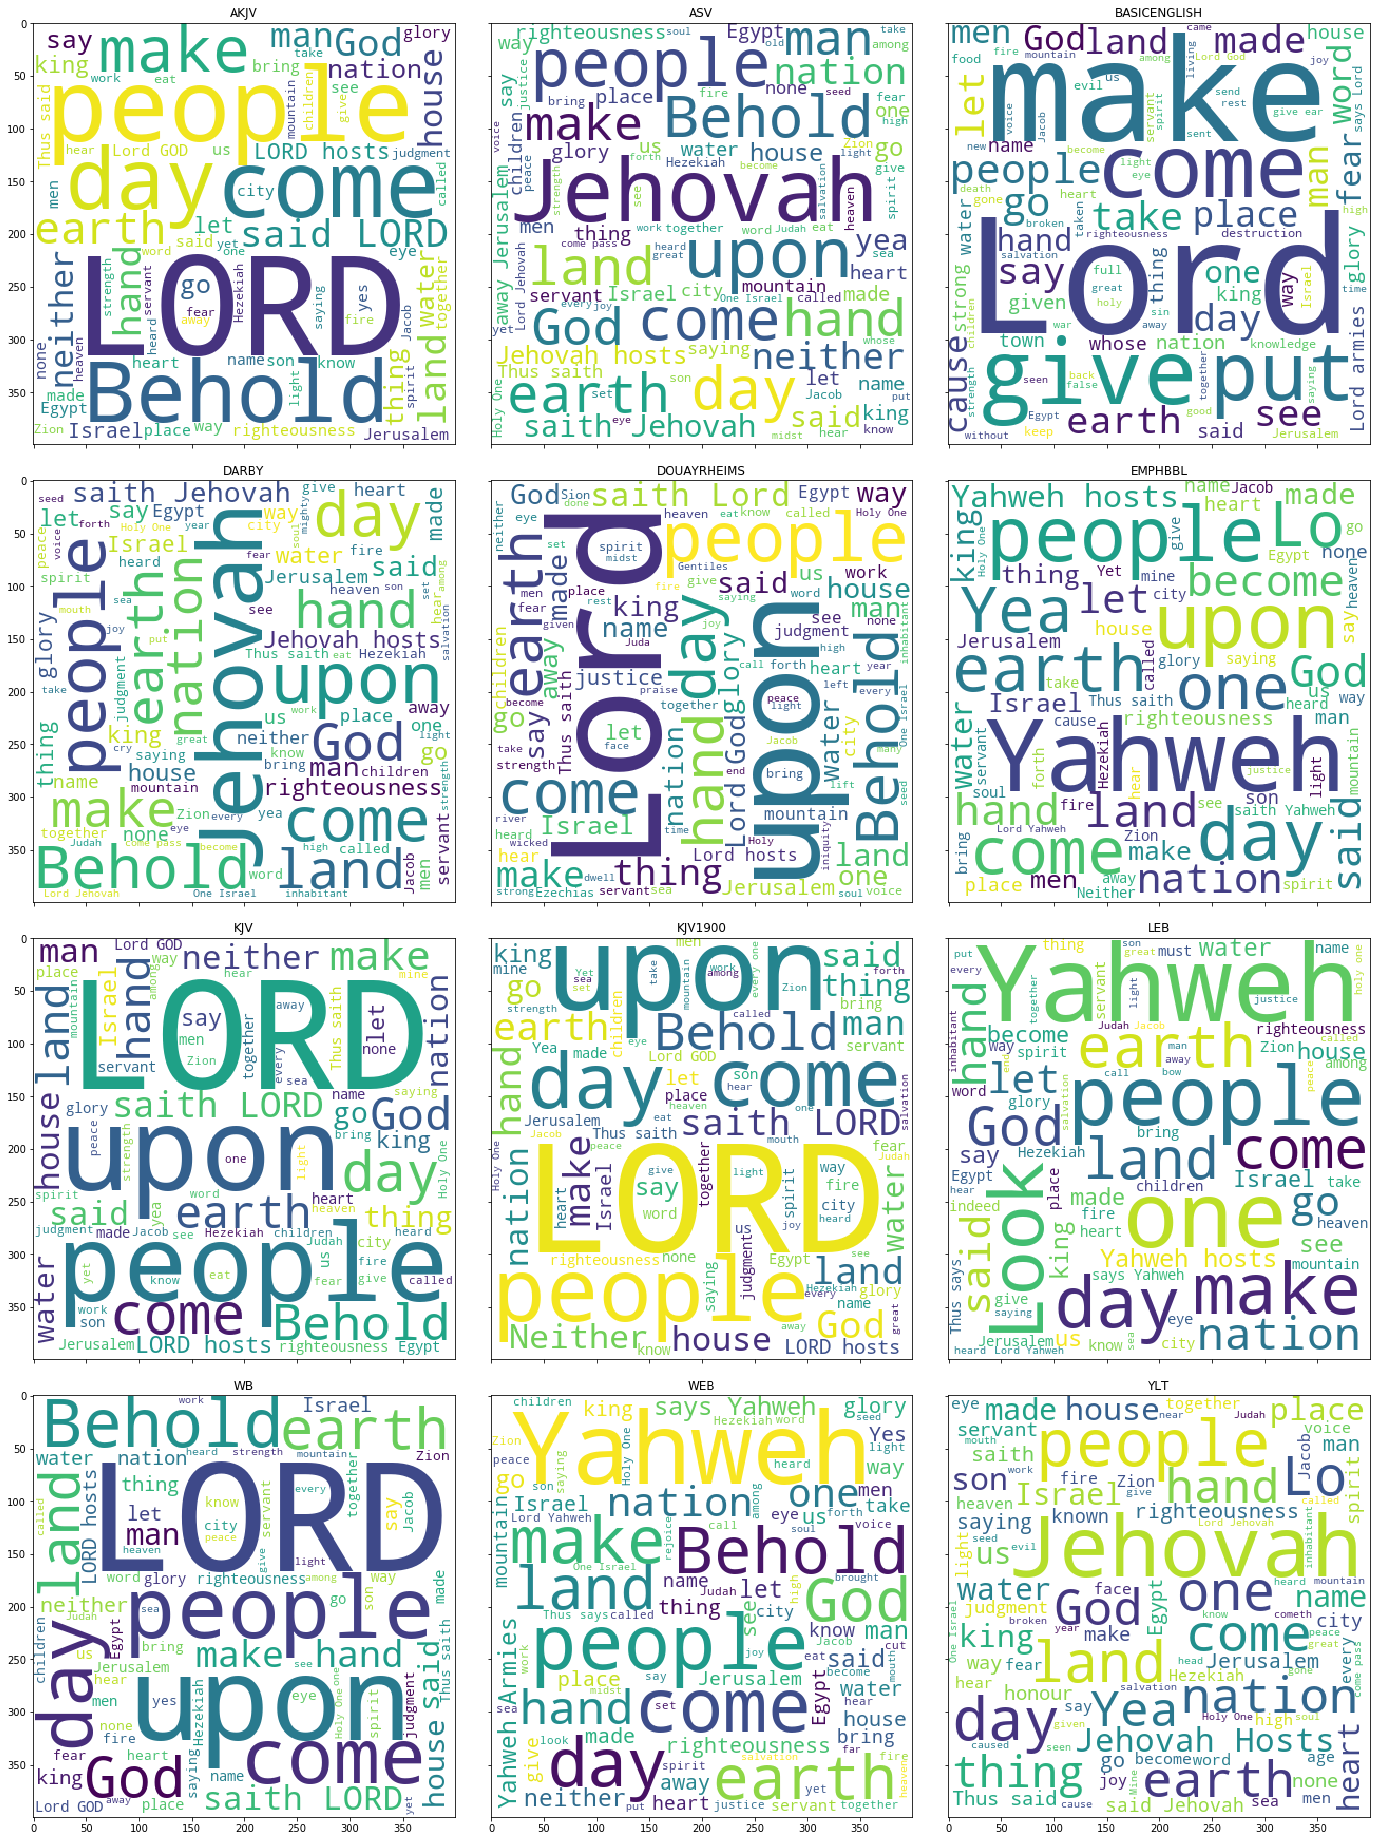

In [35]:
cloud_grid = generate_multi_wordcloud(df=df, version_list=df.version.unique(), display_flag=True,
                                     book='isaiah', stopword_list=stop_list)

In [ ]:
img = get_img_from_fig(cloud_grid)
pillow_image = Image.fromarray(img)
pillow_image.show()

In [ ]:
# display_wordcloud(img_path=pillow_image, width=1300, height=1300)

# Conclusion

At the end, we found that the versions are similar to one another, with some differences that arise.

__Metrics__ <br>

The metrics gave us a superficial means of comparing different versions and seeing how they relate and differ. There seemed to be more similarities overall than differences.  The 4 general statistics used to quantify and visualize the differences were *sum, mean, median,* and _mode._  As we looked at the sums, the character counts were almost identical across all versions of the Bibles compared.  

The main metrics that saw the most drastic differences from version to version were **punctuation_count, title_word_count,** and **upper_case_word_count.**  

In the graph below, the upper case word count is significantly higher for _AKJV, KJV, KJV1900, and WB_ versions.  Versions of the KJV are noted to be more poetic in interpretation, as well as in the printing of the verses. This same philosophy
It is possible that the other versions happen to be lower due to new scripts and advancements in translations that made prior readings more clear and understandable.  This difference in the upper case count also points towards a shift in pronouns and titles used to identify GOD vs those used to identify man.

![Average upper_case_word_count_by_verse](./assets/resources/images/average_upper_case_word_count_by_verse.png)


To better view the differences in the metrics, I highly recommend running the Dashboard  app.py file, contained within the repository.  Also looking further into the philosophies behind each translation may answer some of the trends visible within the metrics.

__Word2Vec__ <br>

Modeling in Word2Vec was very interesting.  Many of the versions returned at least 2 shared words when we sought to look at words that were most similar.  The results seemed strange once we decided to look at least similar words.  More research would have to be done to better understand what attributed to the difference in results seen.

__Word cloud representation__ <br>

I found it interesting comparing the word cloud generations to one another vs the Word2Vec representations.  In the multi-grid wordclouds, many of the same words appeared accross each available version.  The main difference was the font size.  The wordcloud package in use utlizes word frequency to set the font size of each respective word.  In the grid above, we are looking at the book of Isaiah.  All versions contains the words LORD, but it shows up with different sizes.  For other versions such as the WEB, the personal name of GOD is writtten into the translation, in place of the all caps "LORD."  Many of the older versions carry this practice. Based on the results of the word clouds, we can see that there is still a great deal of commonality among the different versions, despite how language has evolved overtime and how translation techniques and paradigms have grown as well.

At the end of the day, a deeper comparison can be made, but it will take much more human intervention to see the qualitive differences.  This remark does not discourage the use of technology to help observe difference in versions. There is still so much more that we can create code to identify.  This is very exciting to me because there is so much more room in understanding Biblical text and developign translations that will better communicate the Bible's central theme to new generations. Data Science can play a very substantial role in bridging the communication gap.

# Future Works & Additions

* Add a customizable lematizer to take care of different forms of the same word.
  Ex: said, saith, came, come, cometh
* Develop functionality for the Dash app that will generate the different word cloud images and pass them through a CNN to find which ones are the most similar
* Add functionality that would use the Word2Vec to determine uniqueness vs similarities of the vectors returned.
* Make the wordcloud grid available in the Dash app, where each grid would be a subplot that users can interact with
* Add similar word functionality to the Dash to allow users to see the output of the Word2Vec models in real-time
* Extend the project to automatically compare and contrast other documents
* Using a CNN on the different word clouds generated and trainning it to identify versions that are closest, based on the text passed in and|or the word cloud images generated. 